In [1]:
from typing import List, Tuple, Set, TypeVar

def regular_join[K, V1, V2](left: Set[Tuple[K, V1]], right: Set[Tuple[K, V2]]) -> List[Tuple[K, V1, V2]]:
    output: List[Tuple[K, V1, V2]] = []
    for left_key, left_value in left:
        for right_key, right_value in right:
            if left_key == right_key:
                output.append((left_key, left_value, right_value))

    return output

employees = {(0, "kristjan"), (1, "mark"), (2, "mike")}
salaries = {(2, "40000"), (0, "38750"), (1, "50000")}

employees_salaries = regular_join(employees, salaries)
print(f"Regular join: {employees_salaries}")

Regular join: [(0, 'kristjan', '38750'), (1, 'mark', '50000'), (2, 'mike', '40000')]


In [2]:
from pydbsp.zset import ZSet
from pydbsp.zset.functions.bilinear import join

employees_zset = ZSet({k: 1 for k in employees})
salaries_zset = ZSet({k: 1 for k in salaries})
employees_salaries_zset = join(
    employees_zset,
    salaries_zset,
    lambda left, right: left[0] == right[0],
    lambda left, right: (left[0], left[1], right[1]),
)
print(f"ZSet join: {employees_salaries_zset}")

ZSet join: {(0, 'kristjan', '38750'): 1, (1, 'mark', '50000'): 1, (2, 'mike', '40000'): 1}


In [3]:
from pydbsp.zset import ZSetAddition
from pydbsp.stream import Stream, StreamHandle
from pydbsp.stream.operators.linear import Integrate
from pydbsp.zset.operators.bilinear import LiftedJoin

group = ZSetAddition()
employees_stream = Stream(group)
employees_stream_handle = StreamHandle(lambda: employees_stream)
employees_stream.send(employees_zset)

salaries_stream = Stream(group)
salaries_stream_handle = StreamHandle(lambda: salaries_stream)
salaries_stream.send(salaries_zset)

join_cmp = lambda left, right: left[0] == right[0]
join_projection = lambda left, right: (left[0], left[1], right[1])

integrated_employees = Integrate(employees_stream_handle)
integrated_salaries = Integrate(salaries_stream_handle)
stream_join = LiftedJoin(
    integrated_employees.output_handle(),
    integrated_salaries.output_handle(),
    join_cmp,
    join_projection,
)
integrated_employees.step()
integrated_salaries.step()
stream_join.step()
print(f"ZSet stream join: {stream_join.output().latest()}")

ZSet stream join: {(0, 'kristjan', '38750'): 1, (1, 'mark', '50000'): 1, (2, 'mike', '40000'): 1}


In [4]:
from pydbsp.stream.operators.bilinear import Incrementalize2

incremental_stream_join = Incrementalize2(
    employees_stream_handle,
    salaries_stream_handle,
    lambda left, right: join(left, right, join_cmp, join_projection),
    group,
)
incremental_stream_join.step()
print(f"Incremental ZSet stream join: {incremental_stream_join.output().latest()}")

Incremental ZSet stream join: {(0, 'kristjan', '38750'): 1, (1, 'mark', '50000'): 1, (2, 'mike', '40000'): 1}


In [5]:
employees_stream.send(ZSet({(2, "mike"): -1}))
incremental_stream_join.step()
print(f"Incremental ZSet stream join update: {incremental_stream_join.output().latest()}")

Incremental ZSet stream join update: {(2, 'mike', '40000'): -1}


In [6]:
from pydbsp.indexed_zset.functions.bilinear import join_with_index
from pydbsp.indexed_zset.operators.linear import LiftedIndex

indexer = lambda x: x[0]
index_employees = LiftedIndex(employees_stream_handle, indexer)
index_salaries = LiftedIndex(salaries_stream_handle, indexer)
indexed_join_projection = lambda key, left, right: (key, left[1], right[1])
incremental_sort_merge_join = Incrementalize2(index_employees.output_handle(), index_salaries.output_handle(), lambda l, r: join_with_index(l, r, indexed_join_projection), group)
index_employees.step()
index_salaries.step()
incremental_sort_merge_join.step()
print(f"Incremental indexed ZSet stream join: {incremental_sort_merge_join.output().latest()}")

Incremental indexed ZSet stream join: {(0, 'kristjan', '38750'): 1, (1, 'mark', '50000'): 1, (2, 'mike', '40000'): 1}


In [7]:
index_employees.step()
incremental_sort_merge_join.step()
print(f"Incremental ZSet stream join update: {incremental_sort_merge_join.output().latest()}")

Incremental ZSet stream join update: {(2, 'mike', '40000'): -1}


In [8]:
from random import randrange

names = ("kristjan", "mark", "mike")
max_pay = 100000
fake_data = [((i, names[randrange(len(names))] + str(i)), (i, randrange(max_pay))) for i in range(3, 10003)]
batch_size = 500
fake_data_batches = [fake_data[i : i + batch_size] for i in range(0, len(fake_data), batch_size)]

for batch in fake_data_batches:
    employees_stream.send(ZSet({employee: 1 for employee, _ in batch}))
    salaries_stream.send(ZSet({salary: 1 for _, salary in batch}))

steps_to_take = len(fake_data_batches)

In [9]:
from tqdm.notebook import tqdm
from time import time

time_start = time()
measurements = []
for _ in tqdm(range(steps_to_take)):
    local_time = time()
    integrated_employees.step()
    integrated_salaries.step()
    stream_join.step()
    measurements.append(time() - local_time)
print(f"Time taken - on demand: {time() - time_start}s")

  0%|          | 0/20 [00:00<?, ?it/s]

Time taken - on demand: 20.124440670013428s


In [10]:
import pandas as pd

time_start = time()
pandas_measurements = []
employees_union_df = pd.DataFrame(columns=['id', 'name'])
salaries_union_df = pd.DataFrame(columns=['id', 'salary'])
exs = []

for step in tqdm(range(steps_to_take)):
    local_time = time()
    employees_batch_df = pd.DataFrame([ employee for employee, _ in fake_data_batches[step] ], columns=['id', 'name'])
    employees_union_df = pd.concat([employees_union_df, employees_batch_df], ignore_index=True)

    salaries_batch_df = pd.DataFrame([ salary for _, salary in fake_data_batches[step] ], columns=['id', 'salary'])
    salaries_union_df = pd.concat([salaries_union_df, salaries_batch_df], ignore_index=True)
    
    employees_x_salaries = pd.merge(employees_union_df, salaries_union_df, on=['id'], how='inner')
    exs.append(employees_x_salaries)
    pandas_measurements.append(time() - local_time)

print(f"Time taken - on demand with pandas: {time() - time_start}s")

  0%|          | 0/20 [00:00<?, ?it/s]

Time taken - on demand with pandas: 0.04794740676879883s


In [11]:
time_start = time()
incremental_measurements = []
for _ in tqdm(range(steps_to_take)):
    local_time = time()
    incremental_stream_join.step()
    incremental_measurements.append(time() - local_time)
print(f"Time taken - incremental: {time() - time_start}s")

  0%|          | 0/20 [00:00<?, ?it/s]

Time taken - incremental: 3.2658674716949463s


In [12]:
time_start = time()
incremental_with_index_measurements = []
for _ in tqdm(range(steps_to_take)):
    local_time = time()
    index_employees.step()
    index_salaries.step()
    incremental_sort_merge_join.step()
    incremental_with_index_measurements.append(time() - local_time)
print(f"Time taken - incremental with index: {time() - time_start}s")

  0%|          | 0/20 [00:00<?, ?it/s]

Time taken - incremental with index: 0.24533510208129883s


<Axes: xlabel='t', ylabel='seconds'>

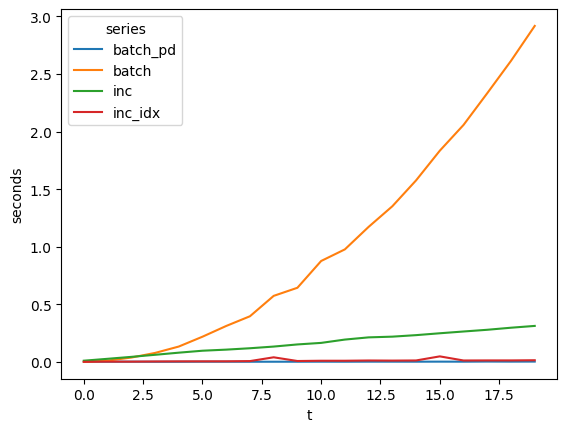

In [14]:
import seaborn as sns
    
df = pd.DataFrame({ "batch_pd": pandas_measurements, "batch": measurements, "inc": incremental_measurements, "inc_idx": incremental_with_index_measurements, "t": list(range(steps_to_take)) })
df_ready = pd.melt(df, id_vars=['t'], value_vars=['batch_pd', 'batch', 'inc', 'inc_idx'], var_name='series', value_name='seconds')

sns.lineplot(data=df_ready, x='t', y='seconds', hue='series')

In [15]:
batch_size = 100000

lots_of_fake_data = [((i, names[randrange(len(names))] + str(i)), (i, randrange(max_pay))) for i in range(10000000)]
lots_of_fake_data_batches = [lots_of_fake_data[i : i + batch_size] for i in range(0, len(lots_of_fake_data), batch_size)]

new_pandas_measurements = []
employees_union_df = pd.DataFrame(columns=['id', 'name'])
salaries_union_df = pd.DataFrame(columns=['id', 'salary'])
new_steps_to_take = len(lots_of_fake_data_batches)
results_pandas = [] 

time_start = time()
for step in tqdm(range(new_steps_to_take)):
    local_time = time()
    employees_batch_df = pd.DataFrame([ employee for employee, _ in lots_of_fake_data_batches[step] ], columns=['id', 'name'])
    employees_union_df = pd.concat([employees_union_df, employees_batch_df], ignore_index=True)

    salaries_batch_df = pd.DataFrame([ salary for _, salary in lots_of_fake_data_batches[step] ], columns=['id', 'salary'])
    salaries_union_df = pd.concat([salaries_union_df, salaries_batch_df], ignore_index=True)
    
    employees_x_salaries = pd.merge(employees_union_df, salaries_union_df, on='id', how='inner')
    results_pandas.append(employees_x_salaries)
    new_pandas_measurements.append(time() - local_time)

print(f"Time taken - on demand with pandas: {time() - time_start}s")

  0%|          | 0/100 [00:00<?, ?it/s]

Time taken - on demand with pandas: 97.98046684265137s


In [16]:
from pydbsp.core import AbelianGroupOperation

class ImmutableDataframeZSet:
    def __init__(self, df: pd.DataFrame) -> None:
        if 'weight' not in df.columns:
            raise ValueError("DataFrame must have a 'weight' column")
        self.inner: List[pd.DataFrame] = [df[df['weight'] != 0]]

    def __repr__(self) -> str:
        return self.inner.__repr__()

    def __eq__(self, other: object) -> bool:
        if not isinstance(other, ImmutableDataframeZSet):
            return False
        if len(self.inner) != len(other.inner):
            return False
        return all(df1 is df2 for df1, df2 in zip(self.inner, other.inner))

class ImmutableDataframeZSetAddition(AbelianGroupOperation[ImmutableDataframeZSet]):
    def add(self, a: ImmutableDataframeZSet, b: ImmutableDataframeZSet) -> ImmutableDataframeZSet:
        if not a.inner:
            return b

        if not b.inner:
            return b
            
        result = ImmutableDataframeZSet(pd.DataFrame(columns=a.inner[0].columns))
        result.inner = a.inner + b.inner
        return result

    def neg(self, a: ImmutableDataframeZSet) -> ImmutableDataframeZSet:
        result = ImmutableDataframeZSet(pd.DataFrame(columns=a.inner[0].columns))
        result.inner = [df.assign(weight=lambda x: -x.weight) for df in a.inner]
        return result

    def identity(self) -> ImmutableDataframeZSet:
        return ImmutableDataframeZSet(pd.DataFrame(columns=['weight']))

immutable_df_abelian_group = ImmutableDataframeZSetAddition()

def join_dfs(
    left_df: pd.DataFrame,
    right_df: pd.DataFrame,
    join_columns: List[str]
):
    if left_df.empty or right_df.empty:
        return pd.DataFrame()
    
    joined = pd.merge(left_df, right_df, on=join_columns, how='inner', suffixes=('_left', '_right'))
    joined['weight'] = joined['weight_left'] * joined['weight_right']
    joined = joined.drop(['weight_left', 'weight_right'], axis=1)

    return joined

def immutable_dataframe_zset_join(
    left_zset: ImmutableDataframeZSet,
    right_zset: ImmutableDataframeZSet,
    join_columns: List[str]
) -> ImmutableDataframeZSet:
    join_tasks = [(left_df, right_df, join_columns) 
                  for left_df in left_zset.inner 
                  for right_df in right_zset.inner]

    result_dfs = [ join_dfs(left, right, join_columns) for left, right, join_columns in join_tasks ]

    non_empty_dfs = [df for df in result_dfs if not df.empty]

    if not non_empty_dfs:
        return immutable_df_abelian_group.identity()

    result = ImmutableDataframeZSet(pd.DataFrame(columns=non_empty_dfs[0].columns))
    result.inner = non_empty_dfs
    return result

In [17]:
employees_with_weight = [ employee + (1,) for employee in employees ]
salaries_with_weight = [ salary + (1,) for salary in salaries ]  

employees_pandas_zset = ImmutableDataframeZSet(pd.DataFrame(employees_with_weight, columns=['id', 'name', 'weight']))
salaries_pandas_zset = ImmutableDataframeZSet(pd.DataFrame(salaries_with_weight , columns=['id', 'salary', 'weight']))

print(immutable_dataframe_zset_join(employees_pandas_zset, salaries_pandas_zset, 'id'))

[   id      name salary  weight
0   0  kristjan  38750       1
1   1      mark  50000       1
2   2      mike  40000       1]


In [18]:
employees_dfs_stream = Stream(immutable_df_abelian_group)
employees_dfs_stream_handle = StreamHandle(lambda: employees_dfs_stream)

salaries_dfs_stream = Stream(immutable_df_abelian_group)
salaries_dfs_stream_handle = StreamHandle(lambda: salaries_dfs_stream)

incremental_pandas_join = Incrementalize2(employees_dfs_stream_handle, salaries_dfs_stream_handle, lambda l, r: immutable_dataframe_zset_join(l, r, ['id']), immutable_df_abelian_group)
incremental_pandas_measurements = []
time_start = time()
for step in tqdm(range(new_steps_to_take)):
    local_time = time()
    employees_batch_df = pd.DataFrame([ employee + (1,) for employee, _ in lots_of_fake_data_batches[step] ], columns=['id', 'name', 'weight'])
    employees_dfs_stream.send(ImmutableDataframeZSet(employees_batch_df))
    
    salaries_batch_df = pd.DataFrame([ salary + (1,) for _, salary in lots_of_fake_data_batches[step] ], columns=['id', 'salary', 'weight'])
    salaries_dfs_stream.send(ImmutableDataframeZSet(salaries_batch_df))
        
    incremental_pandas_join.step()
    incremental_pandas_measurements.append(time() - local_time)
print(f"Time taken - incremental: {time() - time_start}s")

  0%|          | 0/100 [00:00<?, ?it/s]

Time taken - incremental: 20.01264476776123s


In [19]:
from pydbsp.core import AbelianGroupOperation
import cudf as cu

class ImmutableGPUDataframeZSet:
    def __init__(self, df: cu.DataFrame) -> None:
        if 'weight' not in df.columns:
            raise ValueError("DataFrame must have a 'weight' column")
        self.inner: List[cu.DataFrame] = [df[df['weight'] != 0]]

    def __repr__(self) -> str:
        return self.inner.__repr__()

    def __eq__(self, other: object) -> bool:
        if not isinstance(other, ImmutableGPUDataframeZSet):
            return False
        if len(self.inner) != len(other.inner):
            return False
        return all(df1 is df2 for df1, df2 in zip(self.inner, other.inner))

class ImmutableGPUZSetAddition(AbelianGroupOperation[ImmutableGPUDataframeZSet]):
    def add(self, a: ImmutableGPUDataframeZSet, b: ImmutableGPUDataframeZSet) -> ImmutableGPUDataframeZSet:
        if not a.inner:
            return b

        if not b.inner:
            return b
        
        result = ImmutableGPUDataframeZSet(cu.DataFrame(columns=a.inner[0].columns))
        result.inner = a.inner + b.inner
        return result

    def neg(self, a: ImmutableGPUDataframeZSet) -> ImmutableGPUDataframeZSet:
        result = ImmutableGPUDataframeZSet(cu.DataFrame(columns=a.inner[0].columns))
        result.inner = [df.assign(weight=lambda x: -x.weight) for df in a.inner]
        return result

    def identity(self) -> ImmutableGPUDataframeZSet:
        return ImmutableGPUDataframeZSet(cu.DataFrame(columns=['weight']))

immutable_gpu_df_abelian_group = ImmutableGPUZSetAddition()

def join_gpu_dfs(
    left_df: cu.DataFrame,
    right_df: cu.DataFrame,
    join_columns: List[str]
):
    if left_df.empty or right_df.empty:
        return cu.DataFrame()
    
    joined = cu.merge(left_df, right_df, on=join_columns, how='inner', suffixes=('_left', '_right'))
    joined['weight'] = joined['weight_left'] * joined['weight_right']
    joined = joined.drop(['weight_left', 'weight_right'], axis=1)

    return joined

def immutable_gpu_dataframe_zset_join(
    left_zset: ImmutableGPUDataframeZSet,
    right_zset: ImmutableGPUDataframeZSet,
    join_columns: List[str]
) -> ImmutableGPUDataframeZSet:
    join_tasks = [(left_df, right_df, join_columns) 
                  for left_df in left_zset.inner 
                  for right_df in right_zset.inner]

    result_dfs = [ join_gpu_dfs(left, right, join_columns) for left, right, join_columns in join_tasks ]

    non_empty_dfs = [df for df in result_dfs if not df.empty]

    if not non_empty_dfs:
        return immutable_gpu_df_abelian_group.identity()

    result = ImmutableGPUDataframeZSet(cu.DataFrame(columns=non_empty_dfs[0].columns))
    result.inner = non_empty_dfs
    return result

In [20]:
employees_gpu_dfs_stream = Stream(immutable_gpu_df_abelian_group)
employees_gpu_dfs_stream_handle = StreamHandle(lambda: employees_gpu_dfs_stream)

salaries_gpu_dfs_stream = Stream(immutable_gpu_df_abelian_group)
salaries_gpu_dfs_stream_handle = StreamHandle(lambda: salaries_gpu_dfs_stream)

incremental_gpu_pandas_join = Incrementalize2(employees_gpu_dfs_stream_handle, salaries_gpu_dfs_stream_handle, lambda l, r: immutable_gpu_dataframe_zset_join(l, r, ['id']), immutable_gpu_df_abelian_group)
incremental_gpu_pandas_measurements = []
time_start = time()
for step in tqdm(range(new_steps_to_take)):
    local_time = time()
    employees_batch_df = cu.DataFrame([ employee + (1,) for employee, _ in lots_of_fake_data_batches[step] ], columns=['id', 'name', 'weight'])
    employees_gpu_dfs_stream.send(ImmutableGPUDataframeZSet(employees_batch_df))
    
    salaries_batch_df = cu.DataFrame([ salary + (1,) for _, salary in lots_of_fake_data_batches[step] ], columns=['id', 'salary', 'weight'])
    salaries_gpu_dfs_stream.send(ImmutableGPUDataframeZSet(salaries_batch_df))
        
    incremental_gpu_pandas_join.step()
    incremental_gpu_pandas_measurements.append(time() - local_time)
print(f"Time taken - incremental: {time() - time_start}s")

  0%|          | 0/100 [00:00<?, ?it/s]

Time taken - incremental: 27.512064933776855s


<Axes: xlabel='t', ylabel='seconds'>

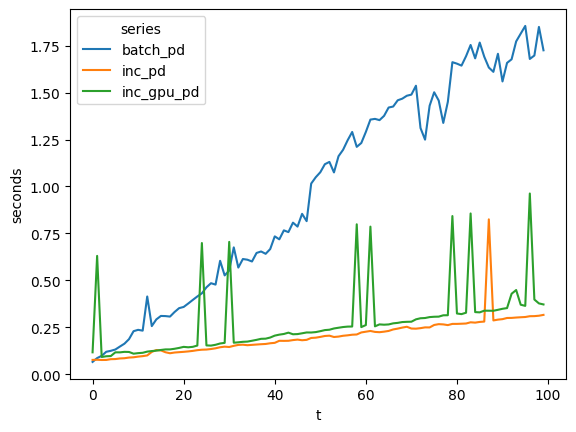

In [21]:
df_inc = pd.DataFrame({ "batch_pd": new_pandas_measurements, "inc_pd": incremental_pandas_measurements, "inc_gpu_pd": incremental_gpu_pandas_measurements ,"t": list(range(new_steps_to_take)) })
df_inc_ready = pd.melt(df_inc, id_vars=['t'], value_vars=['batch_pd', 'inc_pd', 'inc_gpu_pd'], var_name='series', value_name='seconds')


sns.lineplot(data=df_inc_ready, x='t', y='seconds', hue='series')